In [1]:
import pandas as pd
from pyne.material import Material as m
from pyne import nucname
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from sympy import *
from scipy import special as s 
import scipy.integrate
import decayheatfn as dh

/Users/gwenchee/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/Users/gwenchee/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)


In [2]:
data = dh.get_dataframe('SNF_nuclide_2020_07_01.dat')

In [3]:
dh.decay_assembly(254897,data)

45.411773026605

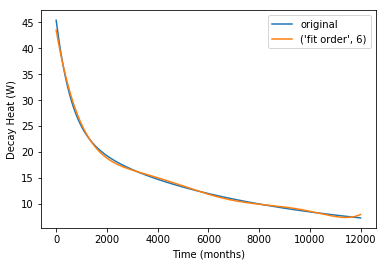

In [4]:
t,Q = dh.get_q(254897,1000,data)
t_new,Q_new,Qcoeffs = dh.q_poly(6,t,Q)
dh.plot_q(t,Q,t_new,Q_new,6)

# Q Equation for all assemblies
Goal: to see the range of decay heat values

In [ ]:
assemblies_100 = data.drop_duplicates(subset='assembly_id')[0:100]
for i in range(1000): 
    assemblyid = assemblies_100['assembly_id'].iloc[i]
    t,Q = dh.get_q(assemblyid,1000,data)
    plt.plot(t,Q) 

In [ ]:
assemblies_100['assembly_id'].iloc[1]

# Temperature Numerical Calculations
Now that we have the Q equation, we can use it in the temperature numerical calculation 

In [5]:
# Constants 

# Granite 
k_g = 2.5 #W/m*K
a_g = 1.13*10**-6 #m2/s

# Length of Canister 
L = 5 #m 
# Canister Spacing 
CS = 10 #m
# Drift spacing 
DS = 20 #m 
# Length of Drift 

# Decay heat from 4 BWR assembly (sample)
q0 = 4*0.060320*10**3#W 

In [6]:
# Temperature Functions 

def Tline(x,y,z,t,a,k,L,num,poly):
    """ This function returns the contribution for Tline
    INPUT Parameters:
        x,y,z : coordinate of interest (0,0,0) refers to the midpoint of the canister
        t: time in the simulation in months [months]
        a: thermal diffusivity of repository material [m^2/s]
        L: length of canister [m]
        num: number of assemblies in the canister 
        poly: symbolic polynomial function for the q equation
        NOTE: when poly is updated for q equation of a canister, the num constant can be removed 
    returns 
    T = Tline contribution in K 
    """
    mtos = 60 * 60 * 24 * 30
    t =  t * mtos 
    Tfunc = lambda tp: (num*poly(tp/mtos)/L)/(t-tp)*exp(-(x**2+z**2)/(4*a*(t-tp)))*(erf(0.5*(y+L/2)/sqrt(a*(t-tp))) - erf(0.5*(y-L/2)/sqrt(a*(t-tp))))
    T = 1/(8*np.pi*k)*scipy.integrate.quad(Tfunc,0,t)[0] #K
    return T

def Tpoint(x,y,t,a,k,num,poly):
    mtos = 60 * 60 * 24 * 30
    t =  t * mtos 
    r = np.sqrt(x**2+y**2)
    Tfunc = lambda tp: (num*poly(tp/mtos)/(t-tp)**(3/2))*exp(-r**2/(4*a*(t-tp)))
    T = 1/(8*k*sqrt(a)*np.pi**(3/2))*scipy.integrate.quad(Tfunc,0,t)[0] #K
    return T

def Tinfline(x,z,t,a,k,num,poly):
    mtos = 60 * 60 * 24 * 30
    t =  t * mtos 
    Tfunc = lambda tp: num*poly(tp/mtos)/(t-tp)*exp(-(x**2+z**2)/(4*a*(t-tp)))
    T = 1/(4*np.pi*k)*scipy.integrate.quad(Tfunc,0,t)[0] #K
    return T

In [8]:
# build symbolic polynomial function
poly1 = np.poly1d(Qcoeffs,variable='tp')

In [9]:
# dummy constants
x1 = 0.1
z1 = 0
a1 = a_g
t1 = 1
y1 = 2.5
L1 = 5
r1 = x1
num1 = 10 # no. of assemblies in canister

In [10]:
# Temperature of placing the first canister 
Tline1 = Tline(x1,y1,z1,t1,a1,k_g,L1,num1,poly1)
print(Tline1)

8.962513696668411


In [11]:
# Temperature of placing the second canister 
Tline2 = Tline(x1,y1,z1,t1,a1,k_g,L1,num1,poly1)
Tpoint2 = Tpoint(x1,y1+L,t1,a1,k_g,num1,poly1)
print(Tline2)
print(Tpoint2)

8.962513696668411
0.00358282787001716


In [12]:
# Temperature of placing the 3rd canister 
Tline3 = Tline(x1,y1,z1,t1,a1,k_g,L1,num1,poly1)
Tpoint31 = Tpoint(x1,y1+L,t1,a1,k_g,num1,poly1)
Tpoint32 = Tpoint(x1,y1+2*L,t1,a1,k_g,num1,poly1)
print(Tline3)
print(Tpoint31)
print(Tpoint32)

8.962513696668411
0.00358282787001716
2.66566136855916e-7


In [13]:
# Temperature of placing a second canister in the second drift
Tline2 = Tline(x1,y1,z1,t1,a1,k_g,L1,num1,poly1)
Tpoint2 = Tpoint(x1,y1+L,t1,a1,k_g,num1,poly1)
Tinf2 = Tinfline(x1+10,z1,t1,a1,k_g,100,poly1)
print(Tline2)
print(Tpoint2)
print(Tinf2)

8.962513696668411
0.00358282787001716
0.0023804778800360226
